In [3]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [4]:
iris = load_iris()

X = iris.data
y = iris.target

print X[4:10]
print y[4:10]

[[ 5.   3.6  1.4  0.2]
 [ 5.4  3.9  1.7  0.4]
 [ 4.6  3.4  1.4  0.3]
 [ 5.   3.4  1.5  0.2]
 [ 4.4  2.9  1.4  0.2]
 [ 4.9  3.1  1.5  0.1]]
[0 0 0 0 0 0]


In [5]:
# Split the data into train and test through random shuffling

np.random.seed(410)
test_size = int(0.2 * len(y))
indices = np.random.permutation(len(X))

X_train = X[ indices[:-test_size]]
y_train = y[ indices[:-test_size]]
X_test = X[ indices[-test_size:]]
y_test = y[ indices[-test_size:]]

print X_train.shape, X_test.shape

(120, 4) (30, 4)


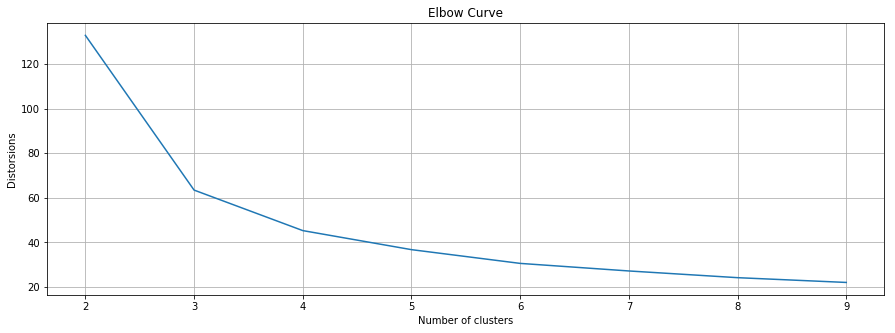

In [15]:
# Method 1 - Elbow Method
distorsions = []
min_k = 2
max_k = int(math.sqrt(X_train.shape[0]))
for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    distorsions.append(kmeans.inertia_)  # keamns provides total within-cluster sum of square

fig = plt.figure(figsize=(15, 5))
plt.plot(range(min_k, max_k), distorsions)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Distorsions')
plt.title('Elbow Curve')


# from the plot below, 3 clusters have the smallest inside angle, so we can choose k=3 for clustering
## from the plot, we can also say the data is not well clustered, because elbow is not very clear to see

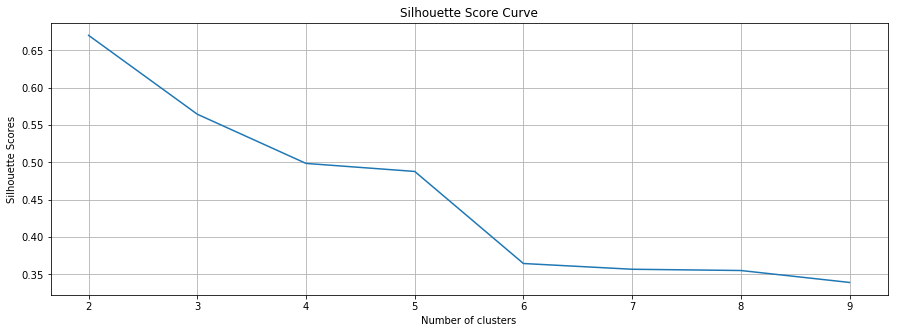

In [25]:
# Method 2 - Silhouette Score

silhouette_scores = []
min_k = 2
max_k = int(math.sqrt(X_train.shape[0]))
for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    labels = kmeans.labels_   # the predicted cluster number for each records
    s_score = silhouette_score(X_train, labels, metric='euclidean', random_state=410) 
    silhouette_scores.append(s_score)
    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(min_k, max_k), silhouette_scores)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette Score Curve')

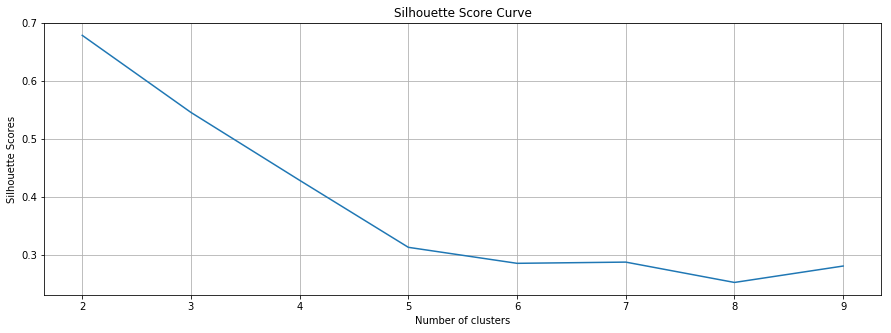

In [23]:
# try normalized data with silhouette_scores
sc = StandardScaler()
silhouette_scores = []
min_k = 2
max_k = int(math.sqrt(X_train.shape[0]))
for k in range(min_k, max_k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(sc.fit_transform(X_train))  # normalized the data
    labels = kmeans.labels_   # the predicted cluster number for each records
    s_score = silhouette_score(X_train, labels, metric='euclidean', random_state=410) 
    silhouette_scores.append(s_score)
    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(min_k, max_k), silhouette_scores)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette Score Curve')

In [ ]:
"""
The number of clusters that give the highest Silhouette Score tend to be optimal
So, in Silhouette Score plot, 2 clusters provide better result
NOTE: cannot choose k=1
"""

In [31]:
# Method 3 - Gap Statistics
# reference: https://anaconda.org/milesgranger/gap-statistic/notebook

from sklearn.datasets.samples_generator import make_blobs
import pandas as pd

def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    np.random.seed(410)
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [41]:
k, gapdf = optimalK(X_train, nrefs=3, maxClusters=15)
print 'Optimal k is: ', k

Optimal k is:  10


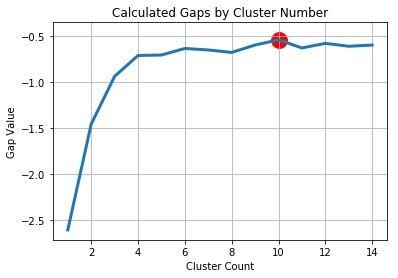

In [42]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Calculated Gaps by Cluster Number')
plt.show()

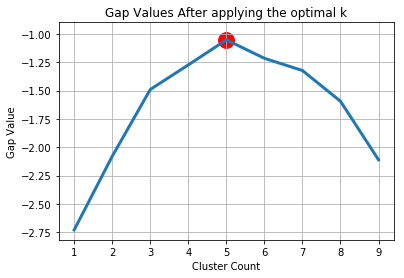

In [43]:
km = KMeans(k)  # apply optimal k
km.fit(X_train)

df = pd.DataFrame(X_train)
df['label'] = km.labels_

num, gapdf = optimalK(km.cluster_centers_, maxClusters=k)
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == num].clusterCount, gapdf[gapdf.clusterCount == num].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values After applying the optimal k')
plt.show()

In [ ]:
"""
I definitely DON'T recommend to use Gap Statistics in python for now....
"""